In [1]:
import numpy as np
from datetime import datetime
import pandas as pd
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
import h5py
from torch.utils.data.dataset import Dataset

In [2]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os,sys
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
torch.cuda.is_available()

PyTorch Version:  1.3.1
Torchvision Version:  0.4.2


True

In [3]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   


class UNet(nn.Module):

    def __init__(self, n_class, in_channels,dropout=0.2):
        super().__init__()
                
        self.dconv_down1 = double_conv(in_channels, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)
        self.dconv_down5 = double_conv(512, 1024)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up4 = double_conv(512 + 1024, 512)
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, in_channels, 1)
        self.fc1 = nn.Linear(25600 ,1024)
        self.bn_fc1 = nn.BatchNorm1d(1024)
        self.dropout1 = nn.Dropout(dropout)
        self.out = nn.Linear(1024, n_class)
        self.relu = nn.ReLU()
#         self.init_weights()
        
#     def init_weights(self):
#         self.dconv_down1.weight.data.normal_(0, 0.01)
#         self.dconv_down2.weight.data.normal_(0, 0.01)
#         self.dconv_down3.weight.data.normal_(0, 0.01)
#         self.dconv_down4.weight.data.normal_(0, 0.01)
#         self.dconv_up3.weight.data.normal_(0, 0.01)
#         self.dconv_up2.weight.data.normal_(0, 0.01)
#         self.dconv_up1.weight.data.normal_(0, 0.01)
#         self.conv_last.weight.data.normal_(0, 0.01)
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        conv4 = self.dconv_down4(x)
        x = self.maxpool(conv4) 
    
        x = self.dconv_down5(x) 
        
        #Classifier
        flatten = x.view(x.size(0),-1)
#         print('fc:',flatten.size())
        y = self.fc1(flatten)
        y = self.bn_fc1(y)
        y = self.relu(y)
        y = self.dropout1(y)

        y = self.out(y)
#         print('out:',x.size())
        prediction = nn.functional.log_softmax(y,dim=1)
        
        x = self.upsample(x)
        x = torch.cat([x, conv4], dim=1)
        x = self.dconv_up4(x)
        
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)
        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        out = self.relu(out)
        return out,prediction

In [4]:
def init_weights(m):
# print(m)
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        m.weight.data.normal_(0, 0.0001)
# print(m.weight)

# net = nn.Sequential(nn.Linear(2, 2), nn.Linear(2, 2))
# net.apply(init_weights)

In [5]:
# from torchsummary import summary

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = UNet(3,1)
# model.apply(init_weights)
# model = model.to(device)
# # model
# summary(model, input_size=(1, 80, 80))

In [6]:
from collections import defaultdict
import torch.nn.functional as F

In [7]:
def calc_loss(out, prediction, target, original, metrics, MSE_weight=0.5):
    CE = F.cross_entropy(prediction, target)
#     BCE = F.binary_cross_entropy_with_logits(prediction, target)
#     out = torch.sigmoid(out)
    MSE = F.mse_loss(out*65535, original*65535)
    
    loss = MSE * MSE_weight + CE * (1 - MSE_weight)
#     loss = MSE * MSE_weight + CE
    
    metrics['CE'] += CE.data.cpu().numpy() * target.size(0)
    metrics['MSE'] += MSE.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    return loss

def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))   

In [8]:
def train_model(model, dataloaders, optimizer1, optimizer2, scheduler1, scheduler2, num_epochs=25):
    start = datetime.now()
    val_acc_history = []
    train_acc_history = []
    val_Bacc_history = []
    train_Bacc_history = []
    val_loss_history = []
    train_loss_history = []
    val_MSEloss_history = []
    lr_history = []
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                if epoch < 5:
                    for param_group in optimizer1.param_groups:
                        print("LR", param_group['lr'])
                        lr_history.append(param_group['lr'])
                else:
                    for param_group in optimizer2.param_groups:
                        print("LR", param_group['lr'])
                        lr_history.append(param_group['lr'])
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
#             running_loss = 0.0
            running_corrects = 0
            confusion_matrix = torch.zeros(3, 3)
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)             

                # zero the parameter gradients
                if epoch < 5:
                    optimizer1.zero_grad()
                else:
                    optimizer2.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs,predictions = model(inputs)
                    loss = calc_loss(outputs, predictions,labels,inputs, metrics,MSE_weight = 1e-8)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        if epoch < 5:
                            optimizer1.step()
                        else:
                            optimizer2.step()
                _, preds = torch.max(predictions, 1)
                # statistics
                epoch_samples += inputs.size(0)
                # statistics
                for t, p in zip(labels.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1
                  
                running_corrects += torch.sum(preds == labels.data)
            
            
            confusionMat = np.asarray(confusion_matrix)
            sumconfusion = np.sum(confusionMat,axis = 1).T

            summat = np.tile(sumconfusion,(3,1)).T
            # print(test)
            percentconfusion = np.divide(confusionMat,summat)
            epoch_acc_balanced = np.sum(np.diagonal(percentconfusion))/3
            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples
            epoch_acc = running_corrects.double() / epoch_samples
            print('{} Acc: {:.4f}'.format(phase, epoch_acc))
            print('{} Bal. Acc: {:.4f}'.format(phase, epoch_acc_balanced))
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                print("saving best model")
                best_acc = epoch_acc
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_Bacc_history.append(epoch_acc_balanced)
                val_loss_history.append(epoch_loss)
                val_MSEloss_history.append(metrics['MSE']/epoch_samples)
                if epoch < 5:
                    scheduler1.step(epoch_loss)
                elif epoch > num_epochs * (2/3):
                    scheduler2.step(epoch_loss)

            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_Bacc_history.append(epoch_acc_balanced)
                train_loss_history.append(epoch_loss)
#             if epoch_acc == 1:
#                 break
        
        if epoch > 3 and val_MSEloss_history[-1] > 1.8e7 :
                break
        print("Total time: %s" %(datetime.now() - start))
        time_elapsed = time.time() - since
        print('Epoch time: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
            
    print('Best val loss: {:4f}'.format(best_loss))
    print('Best val acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,train_acc_history,train_loss_history,val_acc_history,val_loss_history,lr_history,train_Bacc_history,val_Bacc_history

In [9]:
Datadir = "H:\\CellLineClassification\\2DProjections\\2DProjections"

In [10]:
import os

def datapreparation(Datadir):
    trainpath = []
    trainlabel = []
    fpath = []
    traindir = Datadir + "\\HEK"
    for dirpath, dirnames, filenames in os.walk(traindir):
        for filename in [f for f in filenames if f.endswith(".tif")]:
            tempfpath =os.path.join(dirpath, filename)
            fpath.append(tempfpath)
    train = list(range(1,len(fpath)))
    print('HEK data: %d' %(len(train)))
    for i in train:
        trainpath.append(fpath[i])
        trainlabel.append(0)

    fpath = []
    traindir = Datadir + "\\HELA"
    for dirpath, dirnames, filenames in os.walk(traindir):
        for filename in [f for f in filenames if f.endswith(".tif")]:
            tempfpath =os.path.join(dirpath, filename)
            fpath.append(tempfpath)
    train = list(range(1,len(fpath)))
    print('HELA data: %d' %(len(train)))
    for i in train:
        trainpath.append(fpath[i]) 
        trainlabel.append(1)

    fpath = []
    traindir = Datadir + "\\MCF7"
    for dirpath, dirnames, filenames in os.walk(traindir):
        for filename in [f for f in filenames if f.endswith(".tif")]:
            tempfpath =os.path.join(dirpath, filename)
            fpath.append(tempfpath)
    train = list(range(1,len(fpath)))
    print('MCF7 data: %d' %(len(train)))
    for i in train:
        trainpath.append(fpath[i])
        trainlabel.append(2)
    return trainpath,trainlabel

In [11]:
X, Y = datapreparation(Datadir)

HEK data: 3191
HELA data: 3315
MCF7 data: 3764


In [12]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=False)
trainindex = {}
testindex = {}
i = 0
for train_index, test_index in kfold.split(X,Y):
    print("Train Index: ", train_index, "\n")
    print("Test Index: ", test_index)
    trainindex[i] = train_index
    testindex[i] = test_index
    i = i + 1
#fold - 0
# print(trainindex[1])
# indices = trainindex[1]
trainpath =[X[i] for i in trainindex[1]]
testpath =[X[i] for i in testindex[1]]

Train Index:  [  639   640   641 ... 10267 10268 10269] 

Test Index:  [   0    1    2 ... 7255 7256 7257]
Train Index:  [    0     1     2 ... 10267 10268 10269] 

Test Index:  [ 639  640  641 ... 8008 8009 8010]
Train Index:  [    0     1     2 ... 10267 10268 10269] 

Test Index:  [1277 1278 1279 ... 8761 8762 8763]
Train Index:  [    0     1     2 ... 10267 10268 10269] 

Test Index:  [1915 1916 1917 ... 9514 9515 9516]
Train Index:  [   0    1    2 ... 9514 9515 9516] 

Test Index:  [ 2553  2554  2555 ... 10267 10268 10269]


C:\Users\11821\.conda\envs\pytorch-gpu\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [13]:
from skimage import io
import skimage.transform
import scipy
class MyDataset(Dataset):
    def __init__(self, mat_paths, transforms=None):
        self.paths = mat_paths
        self.transforms = transforms
        
    def __getitem__(self, index):
        # Load .mat
#         data = loadmat(self.paths[index])
        data = io.imread(self.paths[index])
#         reshape = skimage.transform.resize(data,(224,224,40))
#         x = torch.from_numpy(reshape.astype(np.float32))
        x = torch.from_numpy(data.astype(np.float32)/65535)
        x = x.unsqueeze(dim = 0)
#         x = np.transpose(x,(2,0,1))
#         x = np.transpose(np.array(data['Data']),(2,0,1))
        if 'HEK' in self.paths[index]:
            label = int(0)
        elif 'HELA' in self.paths[index]:
            label = int(1)
        elif 'MCF7' in self.paths[index]:
            label = int(2)
        if self.transforms:
            x= self.transforms(x)
        return x,label
    
    def __len__(self):
        return len(self.paths)

In [14]:
#actual training
image_datasets = {}
mini_datasets ={}
image_datasets['train'] = MyDataset(trainpath)
image_datasets['val'] = MyDataset(testpath)
# mini_datasets['train'] = MyDataset(minitrainpath)
# mini_datasets['val'] = MyDataset(minivalpath)
# model testing
# image_datasets['train'] = MyDataset(valpath)
# image_datasets['val'] = MyDataset(testpath)
# test_datasets['val'] = MyDataset(testpath)
print('training data volume: ', image_datasets['train'].__len__())
print('validation data volume: ', image_datasets['val'].__len__())

# print('mini-training data volume: ', mini_datasets['train'].__len__())
# print('mini-validation data volume: ', mini_datasets['val'].__len__())

CellName = ['HEK','HELA','MCF7']
image_datasets['train'].__getitem__(0)[0].shape
[ImgTensor,ImgLabel] = image_datasets['train'].__getitem__(0)
print('Cell Label: ',CellName[ImgLabel])
print('image tensor shape: ', ImgTensor.shape)
print('image tensor dtype: ', ImgTensor.dtype)
image_datasets['train'].__getitem__(0)[0]

#Visualize image stacks
from mpl_toolkits.axes_grid1 import make_axes_locatable
image = np.squeeze(ImgTensor.numpy())
print('image shape: ', image.shape)

training data volume:  8216
validation data volume:  2054
Cell Label:  HEK
image tensor shape:  torch.Size([1, 80, 80])
image tensor dtype:  torch.float32
image shape:  (80, 80)


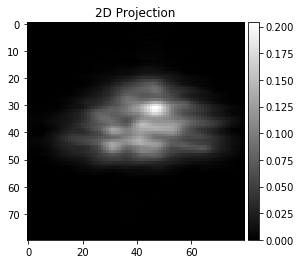

In [15]:
#Visualize image stacks
from mpl_toolkits.axes_grid1 import make_axes_locatable
image = np.transpose(ImgTensor.numpy(), (1,2,0))

def DisplayImage(img,LimMin,LimMax):  
    if img.shape[2]>1:
        for depth in range (0,10):
            plt.subplot(2,5,depth+1)
            plt.imshow(img[:,:,depth*8],vmin=LimMin, vmax=LimMax, cmap ='gray')
            # plt.colorbar()
            plt.title('z = '+ str(depth))
            if depth==9:
                plt.subplot(2,5,depth+1)
                plt.title('z = '+ str(depth))
                ax = plt.gca()
                fig4 = plt.imshow(img[:,:,depth*8],vmin=LimMin, vmax=LimMax, cmap ='gray')

        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(fig4, cax=cax)
        plt.show()
    else:
        fig4 = plt.imshow(np.squeeze(img),vmin=LimMin, vmax=LimMax, cmap ='gray')
        plt.title('2D Projection')
        ax = plt.gca()
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(fig4, cax=cax)
        plt.show()
DisplayImage(image,image.min(),image.max())

In [16]:
print("Initializing Datasets and Dataloaders...")
# Number of classes in the dataset
num_classes = 3

# Batch size for training (change depending on how much memory you have)
batch_size = 64
# Create training and validation datasets
# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=0) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


Fold- 0 : Initializing Datasets and Dataloaders...
Epoch 0/99
----------
LR 0.0001
train: CE: 1.099385, MSE: 38831619.162610, loss: 1.487701
train Acc: 0.3213
train Bal. Acc: 0.3345
val: CE: 1.102071, MSE: 29970243.433301, loss: 1.401774
val Acc: 0.3661
val Bal. Acc: 0.3333
saving best model
Total time: 0:00:53.655308
Epoch time: 0m 54s
Epoch 1/99
----------
LR 0.0001
train: CE: 1.096815, MSE: 38831619.030185, loss: 1.485131
train Acc: 0.3666
train Bal. Acc: 0.3333
val: CE: 1.150051, MSE: 29970243.563778, loss: 1.449753
val Acc: 0.3661
val Bal. Acc: 0.3333
Total time: 0:01:45.317050
Epoch time: 0m 52s
Epoch 2/99
----------
LR 0.0001
train: CE: 1.096213, MSE: 38831618.724440, loss: 1.484529
train Acc: 0.3666
train Bal. Acc: 0.3333
val: CE: 1.173240, MSE: 29970243.653359, loss: 1.472943
val Acc: 0.3661
val Bal. Acc: 0.3333
Total time: 0:02:38.283553
Epoch time: 0m 53s
Epoch 3/99
----------
LR 0.0001
train: CE: 1.096071, MSE: 38831619.041870, loss: 1.484387
train Acc: 0.3666
train Bal. Ac

train: CE: 0.203989, MSE: 133062.705164, loss: 0.205319
train Acc: 0.9200
train Bal. Acc: 0.9208
val: CE: 0.316250, MSE: 114947.461630, loss: 0.317399
val Acc: 0.8700
val Bal. Acc: 0.8716
Total time: 0:22:17.284622
Epoch time: 0m 53s
Epoch 25/99
----------
LR 0.0001
train: CE: 0.204052, MSE: 135147.332956, loss: 0.205403
train Acc: 0.9197
train Bal. Acc: 0.9204
val: CE: 0.618877, MSE: 114975.060089, loss: 0.620027
val Acc: 0.7697
val Bal. Acc: 0.7632
Total time: 0:23:10.175104
Epoch time: 0m 53s
Epoch 26/99
----------
LR 0.0001
train: CE: 0.187421, MSE: 128287.759927, loss: 0.188704
train Acc: 0.9267
train Bal. Acc: 0.9274
val: CE: 0.448667, MSE: 106415.006922, loss: 0.449731
val Acc: 0.8306
val Bal. Acc: 0.8278
Total time: 0:24:03.105727
Epoch time: 0m 53s
Epoch 27/99
----------
LR 0.0001
train: CE: 0.172630, MSE: 124288.106621, loss: 0.173872
train Acc: 0.9332
train Bal. Acc: 0.9338
val: CE: 0.319560, MSE: 106286.477468, loss: 0.320623
val Acc: 0.8690
val Bal. Acc: 0.8682
Total time:

train: CE: 0.033232, MSE: 38601.224497, loss: 0.033618
train Acc: 0.9890
train Bal. Acc: 0.9892
val: CE: 1.010607, MSE: 30588.985691, loss: 1.010913
val Acc: 0.7945
val Bal. Acc: 0.7922
Total time: 0:49:36.016956
Epoch time: 0m 53s
Epoch 56/99
----------
LR 0.0001
train: CE: 0.019331, MSE: 36785.362289, loss: 0.019699
train Acc: 0.9950
train Bal. Acc: 0.9951
val: CE: 0.577634, MSE: 29178.582982, loss: 0.577926
val Acc: 0.8734
val Bal. Acc: 0.8736
Total time: 0:50:28.915191
Epoch time: 0m 53s
Epoch 57/99
----------
LR 0.0001
train: CE: 0.015650, MSE: 38178.741571, loss: 0.016032
train Acc: 0.9951
train Bal. Acc: 0.9952
val: CE: 0.685703, MSE: 29000.650115, loss: 0.685993
val Acc: 0.8637
val Bal. Acc: 0.8623
Total time: 0:51:21.732452
Epoch time: 0m 53s
Epoch 58/99
----------
LR 0.0001
train: CE: 0.020116, MSE: 38910.459821, loss: 0.020505
train Acc: 0.9948
train Bal. Acc: 0.9948
val: CE: 0.521392, MSE: 28774.400533, loss: 0.521680
val Acc: 0.8744
val Bal. Acc: 0.8780
Total time: 0:52:14

train: CE: 0.001439, MSE: 22898.967911, loss: 0.001668
train Acc: 0.9999
train Bal. Acc: 0.9999
val: CE: 0.623895, MSE: 18262.479423, loss: 0.624078
val Acc: 0.8724
val Bal. Acc: 0.8723
Total time: 1:17:06.459038
Epoch time: 0m 53s
Epoch 87/99
----------
LR 5e-05
train: CE: 0.000779, MSE: 22584.778640, loss: 0.001005
train Acc: 1.0000
train Bal. Acc: 1.0000
val: CE: 0.584122, MSE: 18033.151433, loss: 0.584303
val Acc: 0.8812
val Bal. Acc: 0.8813
Total time: 1:17:59.378234
Epoch time: 0m 53s
Epoch 88/99
----------
LR 5e-05
train: CE: 0.000560, MSE: 22377.589739, loss: 0.000784
train Acc: 1.0000
train Bal. Acc: 1.0000
val: CE: 0.615302, MSE: 17865.945543, loss: 0.615481
val Acc: 0.8729
val Bal. Acc: 0.8726
Total time: 1:18:52.311991
Epoch time: 0m 53s
Epoch 89/99
----------
LR 5e-05
train: CE: 0.000785, MSE: 22210.051403, loss: 0.001007
train Acc: 0.9999
train Bal. Acc: 0.9999
val: CE: 0.645489, MSE: 17932.502575, loss: 0.645668
val Acc: 0.8754
val Bal. Acc: 0.8746
Total time: 1:19:45.21

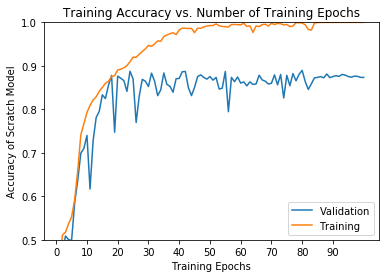

100


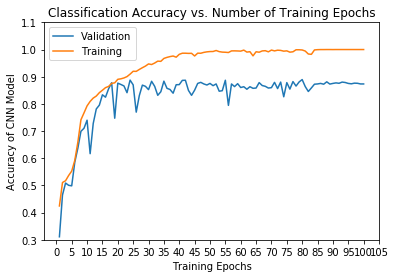

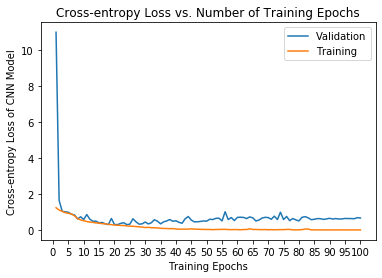

tensor([[625.,   6.,   8.],
        [ 24., 530., 109.],
        [ 10.,  70., 672.]])
[659. 606. 789.]
[[0.97809076 0.00938967 0.01251956]
 [0.0361991  0.7993967  0.16440423]
 [0.01329787 0.0930851  0.89361703]]


C:\Users\11821\.conda\envs\pytorch-gpu\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type UNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\11821\.conda\envs\pytorch-gpu\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\11821\.conda\envs\pytorch-gpu\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\11821\.conda\envs\pytorch-gpu\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + 




Fold- 1 : Initializing Datasets and Dataloaders...
Epoch 0/99
----------
LR 0.0001
train: CE: 1.025885, MSE: 19965665.778968, loss: 1.225542
train Acc: 0.4149
train Bal. Acc: 0.4325
val: CE: 17.392673, MSE: 19662758.656280, loss: 17.589301
val Acc: 0.3106
val Bal. Acc: 0.3333
saving best model
Total time: 0:00:52.947180
Epoch time: 0m 53s
Epoch 1/99
----------
LR 0.0001
train: CE: 0.949629, MSE: 15116797.055501, loss: 1.100797
train Acc: 0.4998
train Bal. Acc: 0.5186
val: CE: 5.562807, MSE: 14046382.220058, loss: 5.703270
val Acc: 0.3130
val Bal. Acc: 0.3358
saving best model
Total time: 0:01:45.880203
Epoch time: 0m 53s
Epoch 2/99
----------
LR 0.0001
train: CE: 0.949023, MSE: 11895570.770691, loss: 1.067978
train Acc: 0.5045
train Bal. Acc: 0.5210
val: CE: 0.888221, MSE: 14130972.690847, loss: 1.029531
val Acc: 0.5370
val Bal. Acc: 0.5526
saving best model
Total time: 0:02:38.766154
Epoch time: 0m 53s
Epoch 3/99
----------
LR 0.0001
train: CE: 0.938694, MSE: 10180670.860273, loss:

train: CE: 0.215803, MSE: 232035.434533, loss: 0.218123
train Acc: 0.9107
train Bal. Acc: 0.9114
val: CE: 0.365594, MSE: 237690.928706, loss: 0.367971
val Acc: 0.8559
val Bal. Acc: 0.8534
Total time: 0:27:20.745695
Epoch time: 0m 53s
Epoch 31/99
----------
LR 0.0001
train: CE: 0.207890, MSE: 215181.009783, loss: 0.210042
train Acc: 0.9149
train Bal. Acc: 0.9157
val: CE: 0.353345, MSE: 227147.547453, loss: 0.355617
val Acc: 0.8705
val Bal. Acc: 0.8769
Total time: 0:28:13.622567
Epoch time: 0m 53s
Epoch 32/99
----------
LR 0.0001
train: CE: 0.193999, MSE: 197512.830848, loss: 0.195974
train Acc: 0.9244
train Bal. Acc: 0.9250
val: CE: 0.235013, MSE: 206680.812074, loss: 0.237079
val Acc: 0.9158
val Bal. Acc: 0.9155
Total time: 0:29:06.507238
Epoch time: 0m 53s
Epoch 33/99
----------
LR 0.0001
train: CE: 0.185832, MSE: 180505.633505, loss: 0.187637
train Acc: 0.9258
train Bal. Acc: 0.9266
val: CE: 0.284796, MSE: 181987.726661, loss: 0.286616
val Acc: 0.8929
val Bal. Acc: 0.8906
Total time:

train: CE: 0.009002, MSE: 53579.366123, loss: 0.009538
train Acc: 0.9988
train Bal. Acc: 0.9988
val: CE: 0.340548, MSE: 52226.882375, loss: 0.341070
val Acc: 0.9133
val Bal. Acc: 0.9135
Total time: 0:54:55.346916
Epoch time: 0m 53s
Epoch 62/99
----------
LR 0.0001
train: CE: 0.003629, MSE: 46934.479655, loss: 0.004099
train Acc: 1.0000
train Bal. Acc: 1.0000
val: CE: 0.312038, MSE: 48565.833100, loss: 0.312523
val Acc: 0.9226
val Bal. Acc: 0.9248
saving best model
Total time: 0:55:48.133899
Epoch time: 0m 53s
Epoch 63/99
----------
LR 0.0001
train: CE: 0.003208, MSE: 45261.843381, loss: 0.003661
train Acc: 0.9998
train Bal. Acc: 0.9998
val: CE: 0.329432, MSE: 50393.388651, loss: 0.329936
val Acc: 0.9167
val Bal. Acc: 0.9178
Total time: 0:56:40.794823
Epoch time: 0m 53s
Epoch 64/99
----------
LR 0.0001
train: CE: 0.005001, MSE: 46736.875666, loss: 0.005469
train Acc: 0.9993
train Bal. Acc: 0.9993
val: CE: 0.329605, MSE: 49159.705472, loss: 0.330097
val Acc: 0.9226
val Bal. Acc: 0.9236
T

val: CE: 0.381871, MSE: 27418.379750, loss: 0.382145
val Acc: 0.9172
val Bal. Acc: 0.9186
Total time: 1:21:16.193852
Epoch time: 0m 53s
Epoch 92/99
----------
LR 1.25e-05
train: CE: 0.000662, MSE: 25710.799549, loss: 0.000919
train Acc: 1.0000
train Bal. Acc: 1.0000
val: CE: 0.378703, MSE: 27024.219670, loss: 0.378973
val Acc: 0.9187
val Bal. Acc: 0.9205
Total time: 1:22:08.903615
Epoch time: 0m 53s
Epoch 93/99
----------
LR 1.25e-05
train: CE: 0.000555, MSE: 25543.669677, loss: 0.000810
train Acc: 1.0000
train Bal. Acc: 1.0000
val: CE: 0.370832, MSE: 27192.099542, loss: 0.371104
val Acc: 0.9221
val Bal. Acc: 0.9241
Total time: 1:23:01.599525
Epoch time: 0m 53s
Epoch 94/99
----------
LR 1.25e-05
train: CE: 0.000588, MSE: 25404.286113, loss: 0.000842
train Acc: 1.0000
train Bal. Acc: 1.0000
val: CE: 0.374693, MSE: 26768.636517, loss: 0.374961
val Acc: 0.9216
val Bal. Acc: 0.9235
Total time: 1:23:54.315596
Epoch time: 0m 53s
Epoch 95/99
----------
LR 1.25e-05
train: CE: 0.000520, MSE: 25

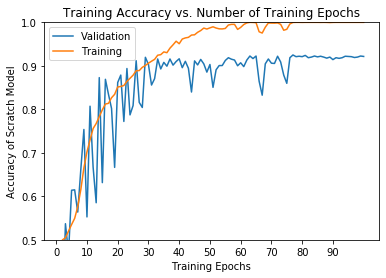

100


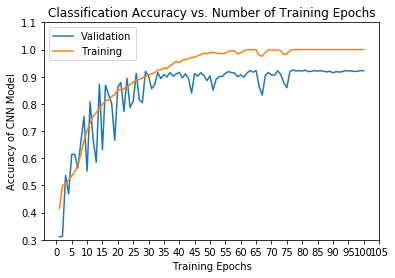

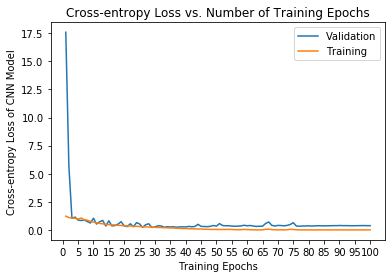

tensor([[627.,   9.,   2.],
        [ 14., 591.,  58.],
        [  9.,  62., 682.]])
[650. 662. 742.]
[[0.98275864 0.01410658 0.0031348 ]
 [0.02111614 0.8914027  0.08748115]
 [0.01195219 0.08233732 0.9057105 ]]



Fold- 2 : Initializing Datasets and Dataloaders...
Epoch 0/99
----------
LR 0.0001
train: CE: 1.097921, MSE: 34581800.993184, loss: 1.443739
train Acc: 0.3595
train Bal. Acc: 0.3344
val: CE: 1.096247, MSE: 46969515.365141, loss: 1.565942
val Acc: 0.3666
val Bal. Acc: 0.3333
saving best model
Total time: 0:00:52.608129
Epoch time: 0m 53s
Epoch 1/99
----------
LR 0.0001
train: CE: 1.096771, MSE: 34581801.300876, loss: 1.442589
train Acc: 0.3665
train Bal. Acc: 0.3333
val: CE: 1.108165, MSE: 46969515.433301, loss: 1.577860
val Acc: 0.3666
val Bal. Acc: 0.3333
Total time: 0:01:45.246970
Epoch time: 0m 53s
Epoch 2/99
----------
LR 0.0001
train: CE: 1.096251, MSE: 34581800.860759, loss: 1.442069
train Acc: 0.3665
train Bal. Acc: 0.3333
val: CE: 1.125941, MSE: 46969514.936709, loss:

train: CE: 0.426171, MSE: 505998.041900, loss: 0.431231
train Acc: 0.8178
train Bal. Acc: 0.8192
val: CE: 173.967369, MSE: 516775.555471, loss: 173.972537
val Acc: 0.3666
val Bal. Acc: 0.3333
Total time: 0:22:19.737279
Epoch time: 0m 53s
Epoch 25/99
----------
LR 0.0001
train: CE: 0.410607, MSE: 424556.948393, loss: 0.414852
train Acc: 0.8298
train Bal. Acc: 0.8311
val: CE: 58.641464, MSE: 715830.606256, loss: 58.648622
val Acc: 0.3228
val Bal. Acc: 0.3333
Total time: 0:23:12.336894
Epoch time: 0m 53s
Epoch 26/99
----------
LR 0.0001
train: CE: 0.406464, MSE: 426194.692369, loss: 0.410725
train Acc: 0.8218
train Bal. Acc: 0.8232
val: CE: 45.667271, MSE: 482507.896026, loss: 45.672096
val Acc: 0.3228
val Bal. Acc: 0.3333
Total time: 0:24:04.977068
Epoch time: 0m 53s
Epoch 27/99
----------
LR 0.0001
train: CE: 0.403090, MSE: 416809.439873, loss: 0.407258
train Acc: 0.8289
train Bal. Acc: 0.8302
val: CE: 33.934970, MSE: 447585.569286, loss: 33.939446
val Acc: 0.3106
val Bal. Acc: 0.3333
T

train: CE: 0.313567, MSE: 209346.252647, loss: 0.315661
train Acc: 0.8690
train Bal. Acc: 0.8705
val: CE: 108.316771, MSE: 614747.056232, loss: 108.322919
val Acc: 0.3228
val Bal. Acc: 0.3333
Total time: 0:49:37.145905
Epoch time: 0m 53s
Epoch 56/99
----------
LR 0.0001
train: CE: 0.320062, MSE: 213453.307951, loss: 0.322196
train Acc: 0.8688
train Bal. Acc: 0.8703
val: CE: 6.516456, MSE: 258916.686329, loss: 6.519045
val Acc: 0.5604
val Bal. Acc: 0.5423
saving best model
Total time: 0:50:29.923844
Epoch time: 0m 53s
Epoch 57/99
----------
LR 0.0001
train: CE: 0.315926, MSE: 193756.097949, loss: 0.317863
train Acc: 0.8727
train Bal. Acc: 0.8740
val: CE: 118.042111, MSE: 275835.986398, loss: 118.044869
val Acc: 0.3666
val Bal. Acc: 0.3333
Total time: 0:51:22.759607
Epoch time: 0m 53s
Epoch 58/99
----------
LR 0.0001
train: CE: 0.305802, MSE: 209645.117028, loss: 0.307898
train Acc: 0.8739
train Bal. Acc: 0.8753
val: CE: 106.032343, MSE: 233704.909688, loss: 106.034680
val Acc: 0.3666
va

val: CE: 42.725666, MSE: 141162.009699, loss: 42.727078
val Acc: 0.3228
val Bal. Acc: 0.3333
Total time: 1:16:11.625533
Epoch time: 0m 53s
Epoch 86/99
----------
LR 5e-05
train: CE: 0.241183, MSE: 120867.510171, loss: 0.242392
train Acc: 0.9021
train Bal. Acc: 0.9036
val: CE: 18.101920, MSE: 158996.540759, loss: 18.103511
val Acc: 0.3885
val Bal. Acc: 0.3910
Total time: 1:17:04.491995
Epoch time: 0m 53s
Epoch 87/99
----------
LR 5e-05
train: CE: 0.243694, MSE: 117358.387491, loss: 0.244868
train Acc: 0.9004
train Bal. Acc: 0.9018
val: CE: 27.855565, MSE: 138675.103670, loss: 27.856952
val Acc: 0.3228
val Bal. Acc: 0.3333
Total time: 1:17:57.320390
Epoch time: 0m 53s
Epoch 88/99
----------
LR 5e-05
train: CE: 0.240067, MSE: 117862.600399, loss: 0.241246
train Acc: 0.9018
train Bal. Acc: 0.9029
val: CE: 69.196338, MSE: 151733.501004, loss: 69.197855
val Acc: 0.3666
val Bal. Acc: 0.3334
Total time: 1:18:50.219584
Epoch time: 0m 53s
Epoch 89/99
----------
LR 5e-05
train: CE: 0.237769, MSE:

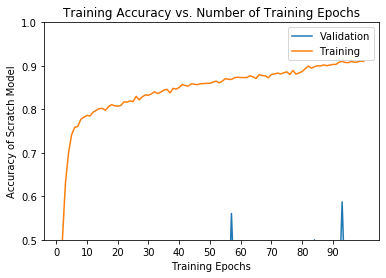

100


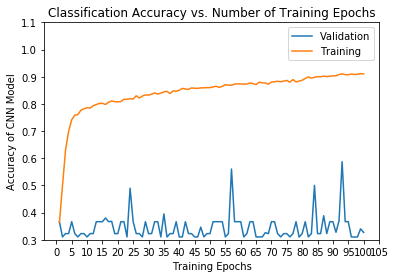

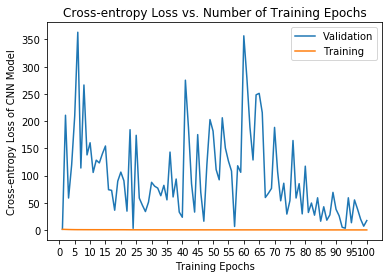

tensor([[510.,   0., 128.],
        [172.,   1., 490.],
        [ 58.,   0., 695.]])
[7.400e+02 1.000e+00 1.313e+03]
[[0.79937303 0.         0.20062695]
 [0.25942686 0.0015083  0.7390649 ]
 [0.07702523 0.         0.92297477]]



Fold- 3 : Initializing Datasets and Dataloaders...
Epoch 0/99
----------
LR 0.0001
train: CE: 1.099028, MSE: 21950766.412853, loss: 1.318536
train Acc: 0.3300
train Bal. Acc: 0.3383
val: CE: 4.779516, MSE: 22894708.800389, loss: 5.008463
val Acc: 0.3666
val Bal. Acc: 0.3333
saving best model
Total time: 0:00:52.698085
Epoch time: 0m 53s
Epoch 1/99
----------
LR 0.0001
train: CE: 0.893671, MSE: 14847229.378773, loss: 1.042144
train Acc: 0.5525
train Bal. Acc: 0.5609
val: CE: 1.682063, MSE: 15058251.266796, loss: 1.832646
val Acc: 0.3228
val Bal. Acc: 0.3333
Total time: 0:01:45.333066
Epoch time: 0m 53s
Epoch 2/99
----------
LR 0.0001
train: CE: 0.889681, MSE: 12615355.026290, loss: 1.015834
train Acc: 0.5686
train Bal. Acc: 0.5763
val: CE: 16.232714, MSE: 127593

val: CE: 0.487245, MSE: 487376.682966, loss: 0.492119
val Acc: 0.7887
val Bal. Acc: 0.7843
saving best model
Total time: 0:26:20.442875
Epoch time: 0m 53s
Epoch 30/99
----------
LR 0.0001
train: CE: 0.271941, MSE: 438668.411149, loss: 0.276328
train Acc: 0.8862
train Bal. Acc: 0.8874
val: CE: 4.964596, MSE: 397196.330742, loss: 4.968568
val Acc: 0.3710
val Bal. Acc: 0.3380
Total time: 0:27:13.080066
Epoch time: 0m 53s
Epoch 31/99
----------
LR 0.0001
train: CE: 0.267045, MSE: 428116.136502, loss: 0.271326
train Acc: 0.8919
train Bal. Acc: 0.8930
val: CE: 1.570349, MSE: 815416.346093, loss: 1.578503
val Acc: 0.5891
val Bal. Acc: 0.6196
Total time: 0:28:05.740887
Epoch time: 0m 53s
Epoch 32/99
----------
LR 0.0001
train: CE: 0.251192, MSE: 387884.446842, loss: 0.255071
train Acc: 0.8908
train Bal. Acc: 0.8919
val: CE: 1.195276, MSE: 511417.553463, loss: 1.200390
val Acc: 0.6008
val Bal. Acc: 0.5831
Total time: 0:28:58.370226
Epoch time: 0m 53s
Epoch 33/99
----------
LR 0.0001
train: CE: 

train: CE: 0.148686, MSE: 251013.949002, loss: 0.151196
train Acc: 0.9429
train Bal. Acc: 0.9436
val: CE: 2.372371, MSE: 344686.933727, loss: 2.375818
val Acc: 0.6217
val Bal. Acc: 0.6016
Total time: 0:53:52.030024
Epoch time: 0m 53s
Epoch 61/99
----------
LR 0.0001
train: CE: 0.156150, MSE: 288637.097356, loss: 0.159036
train Acc: 0.9352
train Bal. Acc: 0.9361
val: CE: 1.087929, MSE: 253216.851699, loss: 1.090461
val Acc: 0.6353
val Bal. Acc: 0.6538
Total time: 0:54:44.699900
Epoch time: 0m 53s
Epoch 62/99
----------
LR 0.0001
train: CE: 0.154117, MSE: 265484.954844, loss: 0.156772
train Acc: 0.9394
train Bal. Acc: 0.9402
val: CE: 1.278550, MSE: 324925.666626, loss: 1.281800
val Acc: 0.6587
val Bal. Acc: 0.6850
Total time: 0:55:37.339268
Epoch time: 0m 53s
Epoch 63/99
----------
LR 0.0001
train: CE: 0.145764, MSE: 279852.300815, loss: 0.148563
train Acc: 0.9401
train Bal. Acc: 0.9407
val: CE: 0.937678, MSE: 279844.575097, loss: 0.940476
val Acc: 0.7089
val Bal. Acc: 0.7318
Total time:

val: CE: 0.750891, MSE: 173698.277454, loss: 0.752628
val Acc: 0.8160
val Bal. Acc: 0.8101
Total time: 1:20:16.814198
Epoch time: 0m 53s
Epoch 91/99
----------
LR 2.5e-05
train: CE: 0.029751, MSE: 143255.488802, loss: 0.031184
train Acc: 0.9946
train Bal. Acc: 0.9947
val: CE: 0.585299, MSE: 169886.857762, loss: 0.586998
val Acc: 0.8427
val Bal. Acc: 0.8400
Total time: 1:21:09.673653
Epoch time: 0m 53s
Epoch 92/99
----------
LR 2.5e-05
train: CE: 0.034268, MSE: 147528.886586, loss: 0.035744
train Acc: 0.9915
train Bal. Acc: 0.9915
val: CE: 0.428206, MSE: 179586.326528, loss: 0.430002
val Acc: 0.8788
val Bal. Acc: 0.8787
saving best model
Total time: 1:22:02.469638
Epoch time: 0m 53s
Epoch 93/99
----------
LR 2.5e-05
train: CE: 0.029554, MSE: 144253.336584, loss: 0.030997
train Acc: 0.9939
train Bal. Acc: 0.9940
val: CE: 0.461143, MSE: 168461.663507, loss: 0.462828
val Acc: 0.8637
val Bal. Acc: 0.8685
Total time: 1:22:55.347840
Epoch time: 0m 53s
Epoch 94/99
----------
LR 2.5e-05
train: 

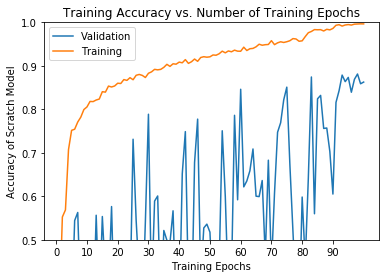

100


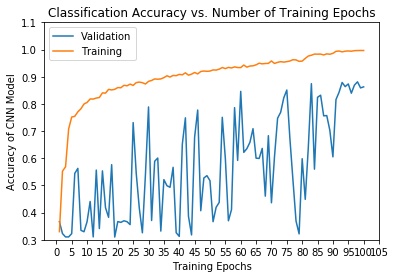

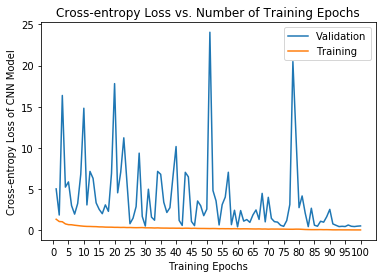

tensor([[606.,  18.,  14.],
        [ 18., 548.,  97.],
        [ 10.,  87., 656.]])
[634. 653. 767.]
[[0.9498433  0.02821317 0.02194357]
 [0.02714932 0.826546   0.14630468]
 [0.01328021 0.11553785 0.87118196]]



Fold- 4 : Initializing Datasets and Dataloaders...
Epoch 0/99
----------
LR 0.0001
train: CE: 0.995032, MSE: 24428706.239533, loss: 1.239319
train Acc: 0.4284
train Bal. Acc: 0.4522
val: CE: 17.627537, MSE: 17939355.517040, loss: 17.806930
val Acc: 0.3106
val Bal. Acc: 0.3333
saving best model
Total time: 0:00:52.951015
Epoch time: 0m 53s
Epoch 1/99
----------
LR 0.0001
train: CE: 0.825611, MSE: 18302401.213242, loss: 1.008635
train Acc: 0.5673
train Bal. Acc: 0.5857
val: CE: 55.827113, MSE: 10996538.276047, loss: 55.937079
val Acc: 0.3666
val Bal. Acc: 0.3333
saving best model
Total time: 0:01:45.828575
Epoch time: 0m 53s
Epoch 2/99
----------
LR 0.0001
train: CE: 0.777455, MSE: 16005283.751704, loss: 0.937507
train Acc: 0.6205
train Bal. Acc: 0.6268
val: CE: 261.778365, MSE

train: CE: 0.263978, MSE: 1191063.767222, loss: 0.275889
train Acc: 0.8970
train Bal. Acc: 0.8973
val: CE: 12.420159, MSE: 769958.568099, loss: 12.427858
val Acc: 0.3296
val Bal. Acc: 0.3529
Total time: 0:26:42.572761
Epoch time: 0m 53s
Epoch 30/99
----------
LR 0.0001
train: CE: 0.274559, MSE: 1349699.519839, loss: 0.288056
train Acc: 0.8931
train Bal. Acc: 0.8935
val: CE: 7.886795, MSE: 735391.345789, loss: 7.894149
val Acc: 0.5740
val Bal. Acc: 0.5589
saving best model
Total time: 0:27:35.478876
Epoch time: 0m 53s
Epoch 31/99
----------
LR 0.0001
train: CE: 0.265841, MSE: 1034106.533106, loss: 0.276182
train Acc: 0.8930
train Bal. Acc: 0.8932
val: CE: 20.992219, MSE: 968377.347493, loss: 21.001902
val Acc: 0.3106
val Bal. Acc: 0.3333
Total time: 0:28:28.274644
Epoch time: 0m 53s
Epoch 32/99
----------
LR 0.0001
train: CE: 0.257209, MSE: 1206975.682814, loss: 0.269278
train Acc: 0.9002
train Bal. Acc: 0.9006
val: CE: 60.194423, MSE: 723908.464155, loss: 60.201663
val Acc: 0.3666
val 

val: CE: 45.873554, MSE: 790604.676424, loss: 45.881460
val Acc: 0.3666
val Bal. Acc: 0.3333
Total time: 0:53:05.636373
Epoch time: 0m 53s
Epoch 60/99
----------
LR 0.0001
train: CE: 0.177305, MSE: 708367.768135, loss: 0.184389
train Acc: 0.9287
train Bal. Acc: 0.9292
val: CE: 4.818467, MSE: 786824.568160, loss: 4.826335
val Acc: 0.4070
val Bal. Acc: 0.3786
Total time: 0:53:58.315461
Epoch time: 0m 53s
Epoch 61/99
----------
LR 0.0001
train: CE: 0.181223, MSE: 872574.047347, loss: 0.189948
train Acc: 0.9281
train Bal. Acc: 0.9285
val: CE: 11.061433, MSE: 506863.078171, loss: 11.066502
val Acc: 0.3856
val Bal. Acc: 0.3537
Total time: 0:54:50.988854
Epoch time: 0m 53s
Epoch 62/99
----------
LR 0.0001
train: CE: 0.170537, MSE: 868157.401168, loss: 0.179219
train Acc: 0.9317
train Bal. Acc: 0.9321
val: CE: 1.928792, MSE: 1533718.903116, loss: 1.944130
val Acc: 0.5823
val Bal. Acc: 0.5864
Total time: 0:55:43.666137
Epoch time: 0m 53s
Epoch 63/99
----------
LR 0.0001
train: CE: 0.174344, MSE

train: CE: 0.069429, MSE: 388472.010285, loss: 0.073314
train Acc: 0.9760
train Bal. Acc: 0.9761
val: CE: 2.412597, MSE: 278265.618306, loss: 2.415379
val Acc: 0.6461
val Bal. Acc: 0.6377
Total time: 1:20:41.821642
Epoch time: 0m 53s
Epoch 91/99
----------
LR 2.5e-05
train: CE: 0.069684, MSE: 361519.719146, loss: 0.073300
train Acc: 0.9757
train Bal. Acc: 0.9757
val: CE: 1.252016, MSE: 260844.718933, loss: 1.254624
val Acc: 0.6417
val Bal. Acc: 0.6627
Total time: 1:21:34.473320
Epoch time: 0m 53s
Epoch 92/99
----------
LR 2.5e-05
train: CE: 0.066222, MSE: 343100.459713, loss: 0.069653
train Acc: 0.9774
train Bal. Acc: 0.9774
val: CE: 4.162436, MSE: 746057.727909, loss: 4.169896
val Acc: 0.4966
val Bal. Acc: 0.4817
Total time: 1:22:27.149358
Epoch time: 0m 53s
Epoch 93/99
----------
LR 2.5e-05
train: CE: 0.067828, MSE: 407517.038218, loss: 0.071903
train Acc: 0.9771
train Bal. Acc: 0.9774
val: CE: 1.197357, MSE: 622041.409506, loss: 1.203578
val Acc: 0.6655
val Bal. Acc: 0.6695
Total ti

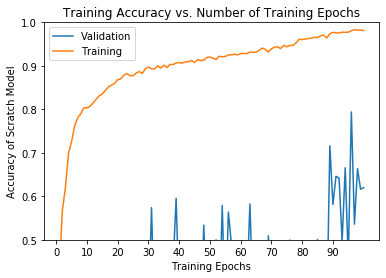

100


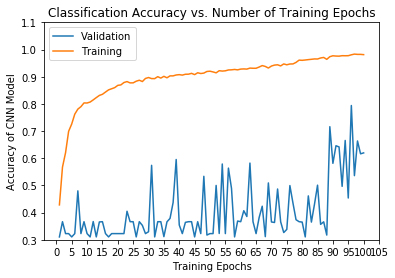

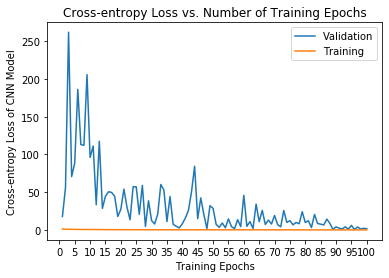

tensor([[586.,  41.,  11.],
        [ 37., 508., 118.],
        [ 28., 188., 537.]])
[651. 737. 666.]
[[0.9184953  0.06426332 0.01724138]
 [0.05580694 0.7662142  0.17797889]
 [0.0371846  0.249668   0.7131474 ]]





In [17]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import copy

for runs in range (0,5):
    print("Fold-",str(runs),": Initializing Datasets and Dataloaders...")
    #Kfold
    trainpath =[X[i] for i in trainindex[runs]]
    testpath =[X[i] for i in testindex[runs]]
    image_datasets = {}
    image_datasets['train'] = MyDataset(trainpath)
    image_datasets['val'] = MyDataset(testpath)

    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=0) for x in ['train', 'val']}

    # Detect if we have a GPU available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    num_class = 3
    in_channel = 1
    num_epochs = 100
    loss_hist_train = []
    while (len(loss_hist_train)<num_epochs/2):
        model = UNet(num_class, in_channel)
        model.apply(init_weights)
        model = model.to(device)

        # freeze backbone layers
        # Comment out to finetune further
        # for l in model.base_layers:
        #     for param in l.parameters():
        #         param.requires_grad = False

        optimizer_ft1 = optim.Adam(model.parameters(), lr=1e-4,betas = (0.9, 0.999),eps=1e-08,weight_decay=0)
        optimizer_ft2 = optim.Adam(model.parameters(), lr=1e-4,betas = (0.9, 0.999),eps=1e-08,weight_decay=0)
        # optimizer_ft1 = optim.Adadelta(model.parameters(), lr=1e-3, rho=0.9, eps=1e-06, weight_decay=0)
        # optimizer_ft2 = optim.Adadelta(model.parameters(), lr=1e-3, rho=0.9, eps=1e-06, weight_decay=0)
        # exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1) 
        exp_lr_scheduler1 = lr_scheduler.ReduceLROnPlateau(optimizer_ft1, mode='min', factor=0.5, patience=5, verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=1, min_lr=1e-7, eps=1e-08)
        exp_lr_scheduler2 = lr_scheduler.ReduceLROnPlateau(optimizer_ft2, mode='min', factor=0.5, patience=5, verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=1, min_lr=1e-7, eps=1e-08)       
        model, scratch_hist_train,loss_hist_train,scratch_hist_val, loss_hist_val,lr_hist,train_Bacc_hist,val_Bacc_hist = train_model(model, dataloaders_dict,optimizer_ft1, optimizer_ft2, exp_lr_scheduler1,exp_lr_scheduler2, num_epochs)
        print('model diverges, reinitializing training....\n')
        print("Fold-",str(runs),": Initializing Datasets and Dataloaders...")
        
    # num_epochs=15
    fname1 = "training_acc_"+str(runs)+".csv"
    np.savetxt(fname1,scratch_hist_train , delimiter=",")
    fname2 = "validation_acc_"+str(runs)+".csv"
    np.savetxt(fname2,scratch_hist_val , delimiter=",")
    fname13 = "training_Bacc_"+str(runs)+".csv"
    np.savetxt(fname13,train_Bacc_hist, delimiter=",")
    fname23 = "validation_Bacc_"+str(runs)+".csv"
    np.savetxt(fname23,val_Bacc_hist, delimiter=",")
    fname20 = "training_loss_"+str(runs)+".csv"
    np.savetxt(fname20,loss_hist_train , delimiter=",")
    fname21 = "validation_loss_"+str(runs)+".csv"
    np.savetxt(fname21,loss_hist_val , delimiter=",")
    fname22 = "learning_rate_"+str(runs)+".csv"
    np.savetxt(fname22,lr_hist , delimiter=",")
    
    shist = []
    shist1 = []

    shist = [h.cpu().numpy() for h in scratch_hist_val]
    shist1 = [h.cpu().numpy() for h in scratch_hist_train]
    print(len(shist))
    plt.title("Training Accuracy vs. Number of Training Epochs")
    plt.xlabel("Training Epochs")
    plt.ylabel("Accuracy of Scratch Model")
    plt.plot(range(1,len(shist)+1),shist[0:len(shist)],label="Validation")
    plt.plot(range(1,len(shist)+1),shist1[0:len(shist)],label="Training")
    plt.ylim((0.5,1.))
    plt.xticks(np.arange(0, num_epochs, 10.0))
    plt.legend()
    fname3 = 'training_curve_'+str(runs)+'.png'
    plt.savefig(fname3)
    plt.show()

    shist = [h.cpu().numpy() for h in scratch_hist_val]
    shist1 = [h.cpu().numpy() for h in scratch_hist_train]
    print(len(shist))
    plt.title("Classification Accuracy vs. Number of Training Epochs")
    plt.xlabel("Training Epochs")
    plt.ylabel("Accuracy of CNN Model")
    plt.plot(range(1,len(shist)+1),shist[0:len(shist)],label="Validation")
    plt.plot(range(1,len(shist)+1),shist1[0:len(shist)],label="Training")
    plt.ylim((0.3,1.1))
    plt.xticks(np.arange(0, len(shist)+10, 5.0))
    plt.legend()
    fname3 = 'training_curve_'+str(runs)+'backup'+'.png'
    plt.savefig(fname3)
    plt.show()

    train_loss = [h for h in loss_hist_train]
    val_loss = [h for h in loss_hist_val]
    plt.title("Cross-entropy Loss vs. Number of Training Epochs")
    plt.xlabel("Training Epochs")
    plt.ylabel("Cross-entropy Loss of CNN Model")
    plt.plot(range(1,len(val_loss)+1),val_loss[0:len(val_loss)],label="Validation")
    plt.plot(range(1,len(train_loss)+1),train_loss[0:len(train_loss)],label="Training")
    #     plt.ylim((0.5,1.05))
    plt.xticks(np.arange(0, len(val_loss)+5, 5.0))
    plt.legend()
    fname31 = 'loss_curve_'+str(runs)+'.png'
    plt.savefig(fname31)
    plt.show()

    confusion_matrix = torch.zeros(num_classes, num_classes)
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(dataloaders_dict['val']):
            inputs = inputs.type(torch.FloatTensor)
            inputs = inputs.to(device)
            classes = classes.to(device)
            _, outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1

    print(confusion_matrix)
    confusionMat = np.asarray(confusion_matrix)
    sumconfusion = np.sum(confusionMat,axis = 0)
    print(sumconfusion)

    import scipy
    sumconfusion = np.sum(confusionMat,axis = 1).T
    # print(np.tile(sumconfusion,(4,1)))
    summat = np.tile(sumconfusion,(3,1)).T
    # print(test)
    percentconfusion = np.divide(confusionMat,summat)
    print(percentconfusion)
    fname4 = "confusion_Mat_UNet_confusionMat_"+str(runs)+".csv"
    np.savetxt(fname4,confusionMat , delimiter=",")
    fname5 = "confusion_Mat_UNet_confusionPer_"+str(runs)+".csv"
    np.savetxt(fname5,percentconfusion , delimiter=",")
    fname6 = 'celltypemodel-unet_2D2D_Run_'+str(runs)+'.pth.tar'

    torch.save(model,fname6)
    print('\n\n')

In [ ]:
runs = 1
# num_epochs=15
fname1 = "training_acc_"+str(runs)+".csv"
np.savetxt(fname1,scratch_hist_train , delimiter=",")
fname2 = "validation_acc_"+str(runs)+".csv"
np.savetxt(fname2,scratch_hist_val , delimiter=",")
fname11 = "training_loss_"+str(runs)+".csv"
np.savetxt(fname11,loss_hist_train , delimiter=",")
fname21 = "validation_loss_"+str(runs)+".csv"
np.savetxt(fname21,loss_hist_val , delimiter=",")

shist = []
shist1 = []

shist = [h.cpu().numpy() for h in scratch_hist_val]
shist1 = [h.cpu().numpy() for h in scratch_hist_train]
print(len(shist))
plt.title("Training Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy of Scratch Model")
plt.plot(range(1,len(shist)+1),shist[0:len(shist)],label="Validation")
plt.plot(range(1,len(shist)+1),shist1[0:len(shist)],label="Training")
plt.ylim((0.5,1.))
plt.xticks(np.arange(0, num_epochs, 10.0))
plt.legend()
fname3 = 'training_curve_'+str(runs)+'.png'
plt.savefig(fname3)
plt.show()

shist = [h.cpu().numpy() for h in scratch_hist_val]
shist1 = [h.cpu().numpy() for h in scratch_hist_train]
print(len(shist))
plt.title("Classification Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy of CNN Model")
plt.plot(range(1,len(shist)+1),shist[0:len(shist)],label="Validation")
plt.plot(range(1,len(shist)+1),shist1[0:len(shist)],label="Training")
plt.ylim((0.3,1.1))
plt.xticks(np.arange(0, len(shist)+10, 5.0))
plt.legend()
fname3 = 'training_curve_'+str(runs)+'backup'+'.png'
plt.savefig(fname3)
plt.show()

train_loss = [h for h in loss_hist_train]
val_loss = [h for h in loss_hist_val]
plt.title("Cross-entropy Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Cross-entropy Loss of CNN Model")
plt.plot(range(1,len(val_loss)+1),val_loss[0:len(val_loss)],label="Validation")
plt.plot(range(1,len(train_loss)+1),train_loss[0:len(train_loss)],label="Training")
#     plt.ylim((0.5,1.05))
plt.xticks(np.arange(0, len(val_loss)+5, 5.0))
plt.legend()
fname31 = 'loss_curve_'+str(runs)+'.png'
plt.savefig(fname31)
plt.show()

confusion_matrix = torch.zeros(num_classes, num_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders_dict['val']):
        inputs = inputs.type(torch.FloatTensor)
        inputs = inputs.to(device)
        classes = classes.to(device)
        _, outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)
confusionMat = np.asarray(confusion_matrix)
sumconfusion = np.sum(confusionMat,axis = 0)
print(sumconfusion)

import scipy
sumconfusion = np.sum(confusionMat,axis = 1).T
# print(np.tile(sumconfusion,(4,1)))
summat = np.tile(sumconfusion,(3,1)).T
# print(test)
percentconfusion = np.divide(confusionMat,summat)
print(percentconfusion)
fname4 = "confusion_Mat_UNet_confusionMat_"+str(runs)+".csv"
np.savetxt(fname4,confusionMat , delimiter=",")
fname5 = "confusion_Mat_UNet_confusionPer_"+str(runs)+".csv"
np.savetxt(fname5,percentconfusion , delimiter=",")
fname6 = 'celltypemodel-unet_80rech_Run_'+str(runs)+'.pth.tar'

torch.save(model,fname6)

In [ ]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.1%}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.tile(np.sum(cf,axis = 0),(3,))]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))
#         accuracy  = np.trace(cf) / 3
        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nBalanced Accuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [ ]:
import seaborn as sns
sns.heatmap(percentconfusion, annot=True,cmap='Blues')


In [ ]:
categories = CellName
make_confusion_matrix(percentconfusion, 
                      #group_names=labels,
                      categories=categories,
                      percent=False,
                      cbar=False,
                      figsize=(4 ,4),
                      cmap='Oranges',title = '2DCNN UNet - 2D Input')

In [ ]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, x):
        return x.view(x.size(0),-1)

In [ ]:
class maxpool(nn.Module):
    def __init__(self):
        super(maxpool, self).__init__()
        self.maxpool = nn.MaxPool2d(2)
        
    def forward(self, x):
        x = self.maxpool(x)
        return x

In [ ]:
# Initialize the non-pretrained version of the model used for this run
scratch_model = torch.load('celltypemodel-unet_80rech_Run_1.pth.tar')
scratch_model_fc = nn.Sequential(*(list(scratch_model.children())[:1]),maxpool(),*(list(scratch_model.children())[1:2]),maxpool(),*(list(scratch_model.children())[2:3]),maxpool(),*(list(scratch_model.children())[3:4]),maxpool(),Flatten(),*(list(scratch_model.children())[-5:-3]))
# scratch_model_fc = nn.Sequential(*list(scratch_model.children())[:-3])
scratch_model_fc = scratch_model_fc.to(device)
scratch_model_fc.eval()

In [ ]:
# list(scratch_model.children())

In [ ]:
#testing
image_datasets = {}
test_datasets ={}
image_datasets['train'] = MyDataset(trainpath)
image_datasets['val'] = MyDataset(testpath)
image_datasets['val'].__getitem__(0)[0].shape

In [ ]:
print("Initializing Datasets and Dataloaders...")
# Number of classes in the dataset
num_classes = 3

# Batch size for training (change depending on how much memory you have)
batch_size = 128
# Create training and test dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=False, num_workers=0) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders_dict['val']):
        inputs = inputs.type(torch.FloatTensor)
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = scratch_model_fc(inputs)
        outputs = outputs.cpu().clone().numpy()
        if i == 0:
            outputlist = outputs
            y = classes.cpu().clone().numpy()
        else:
            outputlist = np.append(outputlist,outputs, axis=0)
            y = np.append(y,classes.cpu().clone().numpy(), axis=0)

In [ ]:
print(len(outputlist))
print(outputlist.shape)
print(y.shape)
outputlist = np.squeeze(outputlist)
print(outputlist.shape)

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
tsne = TSNE(n_components=2, random_state=0,verbose=1, perplexity=45, learning_rate=200,early_exaggeration = 50, n_iter=2000)
X_2d = tsne.fit_transform(outputlist)
CellName = ['HEK293','HELA','MCF7']


In [ ]:
target_ids = range(len(outputlist))
plt.figure(figsize=(4,4))
colors = 'r', 'g', 'b'
for i, c, label in zip(target_ids, colors, CellName):
    plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1],s=3, c=c, label=label,alpha=0.5)
plt.legend()
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('2DCNN UNet - 2D Input')
plt.show()

In [ ]:
scratch_model = torch.load('celltypemodel-unet_80rech_Run_1.pth.tar')
scratch_model = scratch_model.to(device)
scratch_model.eval()

In [ ]:
CellName = ['HEK293','HELA','MCF7']
ImgTensor, Label = image_datasets['val'].__getitem__(1)
image = np.transpose(ImgTensor.numpy(), (1,2,0))
print('Ground Truth Cell Type: ', CellName[Label])
DisplayImage(image,image.min(),image.max())

In [ ]:
inputs = torch.unsqueeze(ImgTensor,0).to(device)
[output,prediction] = scratch_model(inputs)
# output = output.squeeze()
output = output.squeeze()
output = output.cpu().clone().detach().numpy()
_, preds = torch.max(prediction, 1)
preds = preds.cpu().clone().detach()

In [ ]:
# print(output/output.max())
print(output.max())
print(output.shape)
print('Predicted Cell Type: ', CellName[preds])
image = np.transpose(output, (1,2,0))
DisplayImage(image,image.min(),image.max())